In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import networkx as nx
import scipy.cluster.hierarchy as sch

In [3]:
def Degree_rank(G,UWG):
    
    D_w = G.degree(weight='weight')
    D_u = UWG.degree()
    D = pd.DataFrame({'stock': [x[0] for x in list(D_w)], 'Weighted Degree': [x[1] for x in list(D_w)],
                      'Unweighted Degree': [x[1] for x in list(D_u)]})
    D = D.sort_values(by='Weighted Degree', ascending=False)
    D.loc[:, 'CD_W'] = D['Weighted Degree'].to_frame().rank(axis=0,method='average',ascending=False)
    D = D.sort_values(by='Unweighted Degree', ascending=False)
    D.loc[:, 'CD_U'] = D['Unweighted Degree'].to_frame().rank(axis=0,method='average',ascending=False)
    D = D.sort_values(by='stock')

    return D


def Beteenness_centrality_rank(G,UWG):
    BC_w = nx.betweenness_centrality(G, weight='distance')
    BC_u = nx.betweenness_centrality(UWG)
    BC = pd.DataFrame({'stock': BC_w.keys(), 'Weighted Betweenness Centrality': BC_w.values(),
                       'Unweighted Betweenness Centrality': BC_u.values()})
    BC = BC.sort_values(by='Weighted Betweenness Centrality', ascending=False)
    BC.loc[:, 'CBC_W'] = BC['Weighted Betweenness Centrality'].to_frame().rank(axis=0,method='average',ascending=False)
    BC = BC.sort_values(by='Unweighted Betweenness Centrality', ascending=False)
    BC.loc[:, 'CBC_U'] = BC['Unweighted Betweenness Centrality'].to_frame().rank(axis=0,method='average',ascending=False)
    BC = BC.sort_values(by='stock')

    return BC


def Eigenvector_centrality_rank(G,UWG):
    EC_w = nx.eigenvector_centrality(G, weight='weight', max_iter=10000)
    EC_u = nx.eigenvector_centrality(UWG, max_iter=10000)
    EC = pd.DataFrame({'stock': EC_w.keys(), 'Weighted Eigenvector Centrality': EC_w.values(),
                       'Unweighted Eigenvector Centrality': EC_u.values()})
    EC = EC.sort_values(by='Weighted Eigenvector Centrality', ascending=False)
    EC.loc[:, 'CEC_W'] = EC['Weighted Eigenvector Centrality'].to_frame().rank(axis=0,method='average',ascending=False)
    EC = EC.sort_values(by='Unweighted Eigenvector Centrality', ascending=False)
    EC.loc[:, 'CEC_U'] = EC['Unweighted Eigenvector Centrality'].to_frame().rank(axis=0,method='average',ascending=False)
    EC = EC.sort_values(by='stock')

    return EC


def Eccentricity_rank(G,UWG):
    stock_list = list(G.nodes)
    E = pd.DataFrame({'stock': [], 'Weighted Eccentricity': [], 'Unweighted Eccentricity': []})
    for i in range(len(stock_list)):
        E.loc[i] = [stock_list[i],
                    max(nx.single_source_dijkstra_path_length(G, stock_list[i], weight='distance').values()),
                    max(nx.single_source_shortest_path_length(UWG, stock_list[i]).values())]
    E = E.sort_values(by='Weighted Eccentricity')
    E.loc[:, 'CE_W'] = E['Weighted Eccentricity'].to_frame().rank(axis=0,method='average',ascending=True)
    E = E.sort_values(by='Unweighted Eccentricity')
    E.loc[:, 'CE_U'] = E['Unweighted Eccentricity'].to_frame().rank(axis=0,method='average',ascending=True)
    E = E.sort_values(by='stock')

    return E


def Closeness_centrality_rank(G,UWG):
    C_w = nx.closeness_centrality(G, distance='distance')
    C_u = nx.closeness_centrality(UWG)
    C = pd.DataFrame({'stock': C_w.keys(), 'Weighted Closeness': C_w.values(),
                      'Unweighted Closeness': C_u.values()})
    C = C.sort_values(by='Weighted Closeness')
    C.loc[:, 'CC_W'] = C['Weighted Closeness'].to_frame().rank(axis=0,method='average',ascending=True) # 이거 Pozzi 2013과 다른 방식인 것 기억할 것
    C = C.sort_values(by='Unweighted Closeness')
    C.loc[:, 'CC_U'] = C['Unweighted Closeness'].to_frame().rank(axis=0,method='average',ascending=True) # 이거 Pozzi 2013과 다른 방식인 것 기억할 것
    C = C.sort_values(by='stock')

    return C

In [4]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems: #총 군집수-1 >= 총 asset 수
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0])  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

def downside_risk(returns, risk_free=0):
    adj_returns = returns - risk_free
    sqr_downside = np.square(np.clip(adj_returns, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside) * 252)

def MDD(data):
    data = (data+1).cumprod()
    roll_max = data.cummax()
    daily_drawdown = data/roll_max -1.0
    MDD = daily_drawdown.cummin()
    return (min(MDD.values)) 

def MDU(data):
    data = (data+1).cumprod()
    roll_max = data.cummin()
    daily_drawdown = data/roll_max -1.0
    MDD = daily_drawdown.cummax()
    return (max(MDD.values))

def get_hrp_weights(data):
    cov_mat = data.cov()
    corr_mat = data.corr()
    corr_dist_mat = np.sqrt(0.5*(1-corr_mat)) #distance metric으로 변환
    hierarcgy_link = sch.linkage(corr_dist_mat,'single')
    sortIx = getQuasiDiag(hierarcgy_link)
    sortIx = corr_mat.index[sortIx].tolist()
    hrp = getRecBipart(cov_mat, sortIx).sort_index()
    return hrp

In [5]:
SP500_FULL = pd.read_csv('SP500_FULL.csv',index_col='Unnamed: 0')
SP500_FULL

,GR.N^G12,BAX.N,PWJ.N^K00,TRB.N^L07,MII.N^F99,VRTX.OQ,LYV.N,KR.N,UNP.N,MRO.N,...,SO.N,TGT.N,FMC.N,DELL.OQ^J13,BMET.OQ^J07,HSP.N^I15,CSR.N^F00,IDXX.OQ,WB.N^A09,SEE.N
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1995-01-03,21.8750,7.639566,NaN,13.59375,NaN,NaN,NaN,3.046875,11.71875,5.046203,...,19.875,5.833333,6.765336,NaN,5.944439,NaN,22.750,NaN,20.8750,NaN
1995-01-04,22.1875,7.741427,NaN,13.62500,NaN,NaN,NaN,3.062500,11.71875,5.046203,...,20.125,5.822917,6.765336,NaN,6.277772,NaN,22.875,NaN,21.0625,NaN
1995-01-05,22.1250,7.741427,NaN,13.62500,NaN,NaN,NaN,3.109375,11.96875,5.084144,...,20.000,5.916667,6.779916,NaN,6.555549,NaN,22.875,NaN,21.0000,NaN
1995-01-06,21.9375,7.775380,NaN,13.53125,NaN,NaN,NaN,3.109375,12.09375,5.046203,...,20.125,5.875000,6.779916,NaN,6.499994,NaN,22.750,NaN,21.3125,NaN
1995-01-09,22.0000,7.673519,NaN,13.40625,NaN,NaN,NaN,3.125000,11.87500,5.008262,...,19.875,5.708333,6.809077,NaN,6.444438,NaN,22.875,NaN,21.3750,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-25,NaN,73.800000,NaN,NaN,NaN,201.33,85.89,45.800000,221.29000,11.800000,...,65.870,251.150000,92.900000,NaN,NaN,NaN,NaN,676.42,NaN,61.17
2021-08-26,NaN,73.770000,NaN,NaN,NaN,198.25,84.75,45.170000,220.98000,11.520000,...,66.140,248.960000,93.600000,NaN,NaN,NaN,NaN,673.36,NaN,60.67
2021-08-27,NaN,73.970000,NaN,NaN,NaN,199.92,86.90,45.490000,221.43000,12.010000,...,65.990,249.180000,93.070000,NaN,NaN,NaN,NaN,668.27,NaN,61.07


In [6]:
SP500_DELIST = pd.read_csv('S&P_delist.csv',encoding='cp949')
SP500_DELIST

,Ticker,Reason
0,UA/UAA,Market capitalization change.[5]
1,IPGP,Market capitalization change.[5]
2,CERN,S&P 500 constituent Oracle Corp. acquired Cern...
3,PBCT,S&P 500 constituent M&T Bank Corp. acquired Pe...
4,INFO,S&P 500 constituent S&P Global Inc. acquired I...
...,...,...
285,RAD,Market Cap change.[229]
286,TMC,Tribune Co. acquired Times Mirror.[230]
287,SMS,Siemens AG acquired Shared Medical Systems.[231]
288,LDW,Market capitalization change.[232]


In [7]:
positive = []
for row in SP500_DELIST.index:
    line =  SP500_DELIST.loc[row,'Reason']
    for keyword in ['acquired','spun off','Acquired','Spun off','Private','private','is being bought by','Company split','spin-off merged',
                   'split','acquires','merger','spins off','taken over','merged','separated','replaced']:
        if keyword in line:
            positive.append(SP500_DELIST.loc[row,'Ticker'])

Figure 4. Snapshots of the full-correlation MST

/var/folders/tq/5vll538x41n7rfrrk7682rbh0000gn/T/ipykernel_52870/769270444.py:56: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hierarcgy_link = sch.linkage(corr_dist_mat,'single')


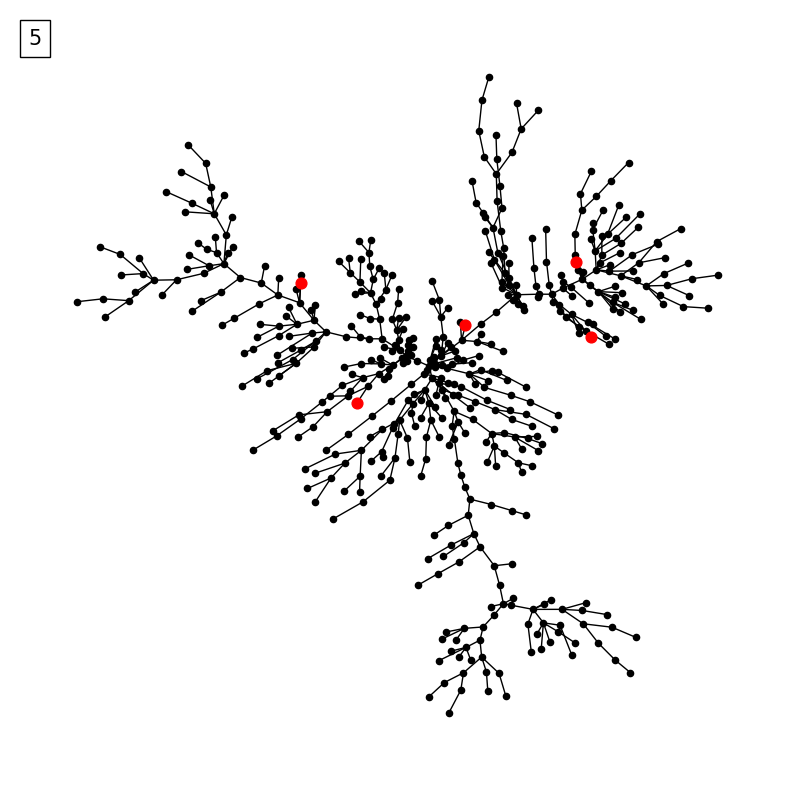

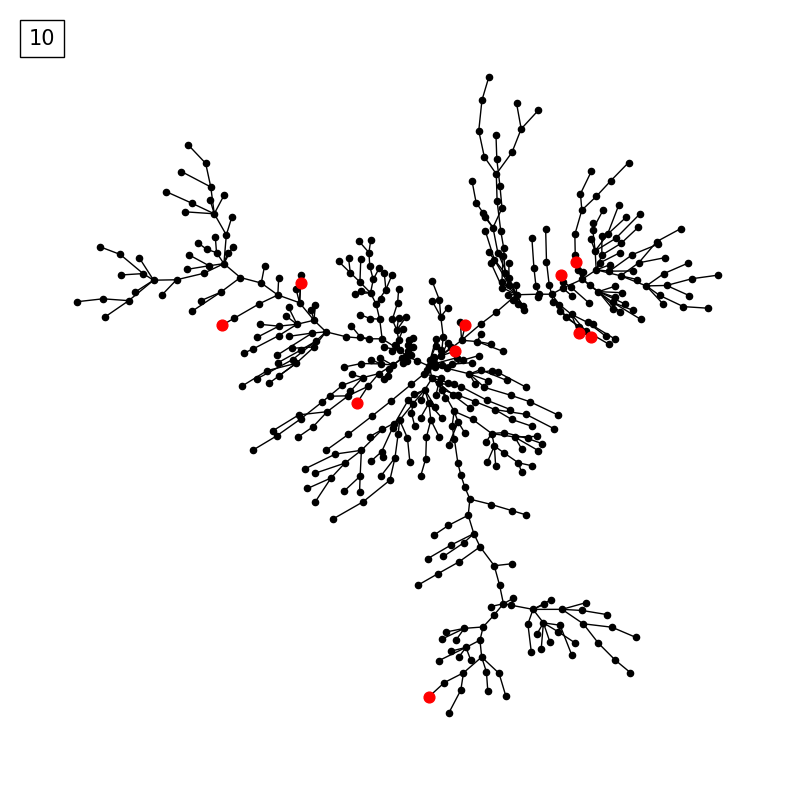

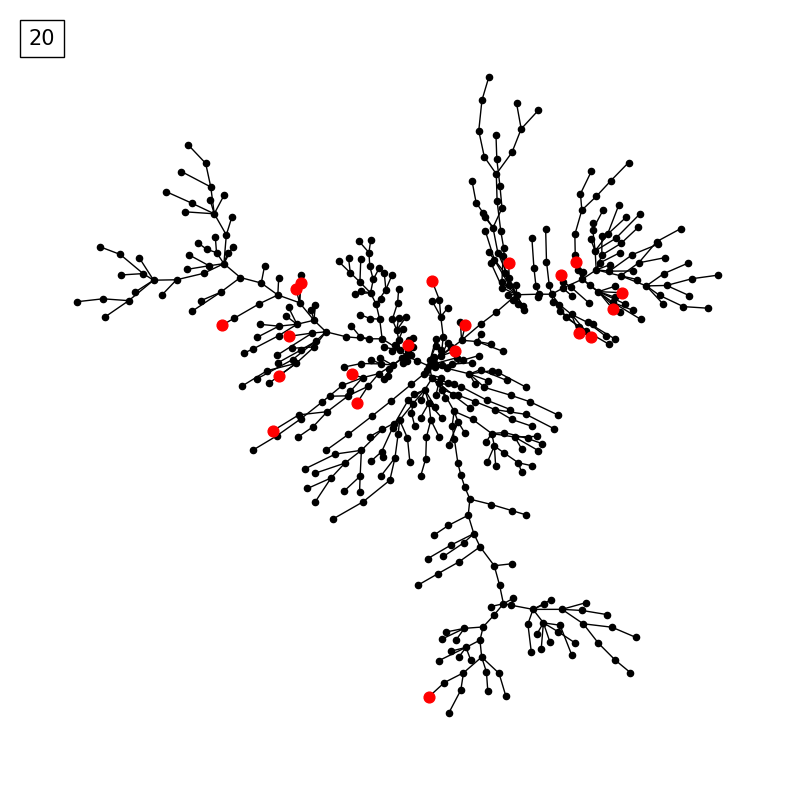

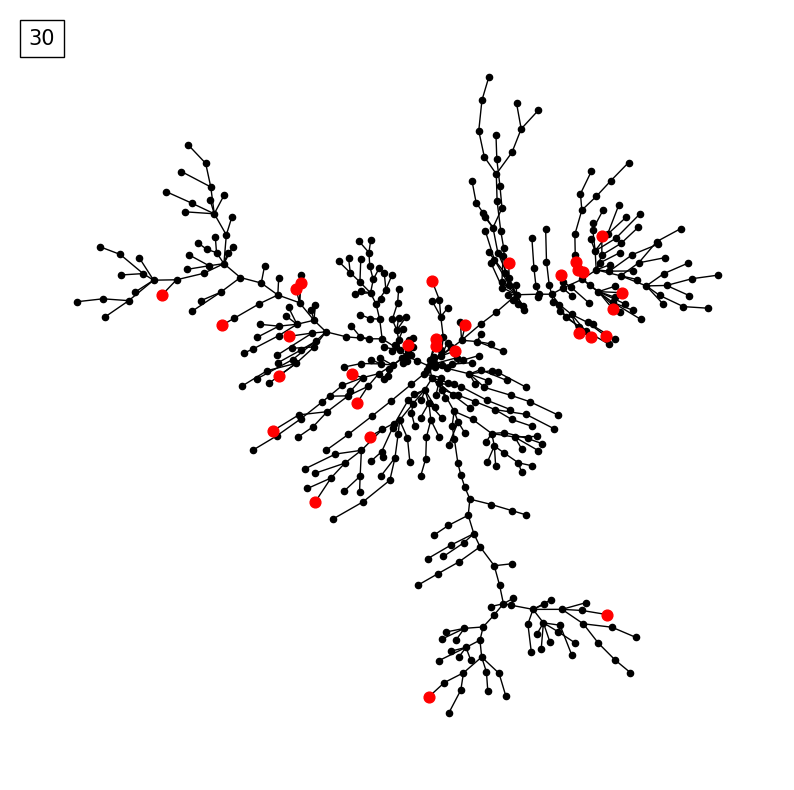

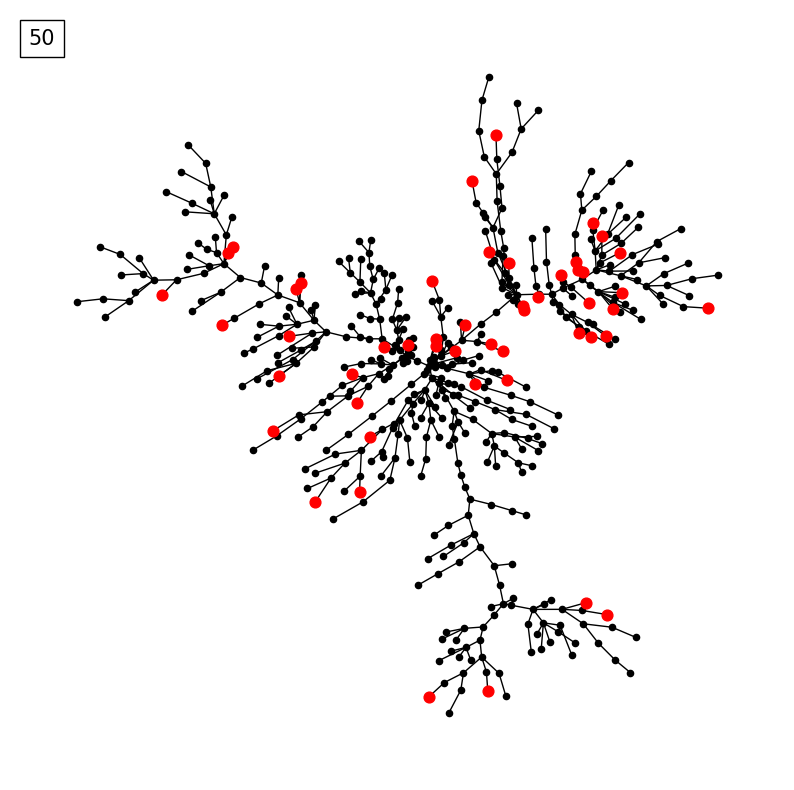

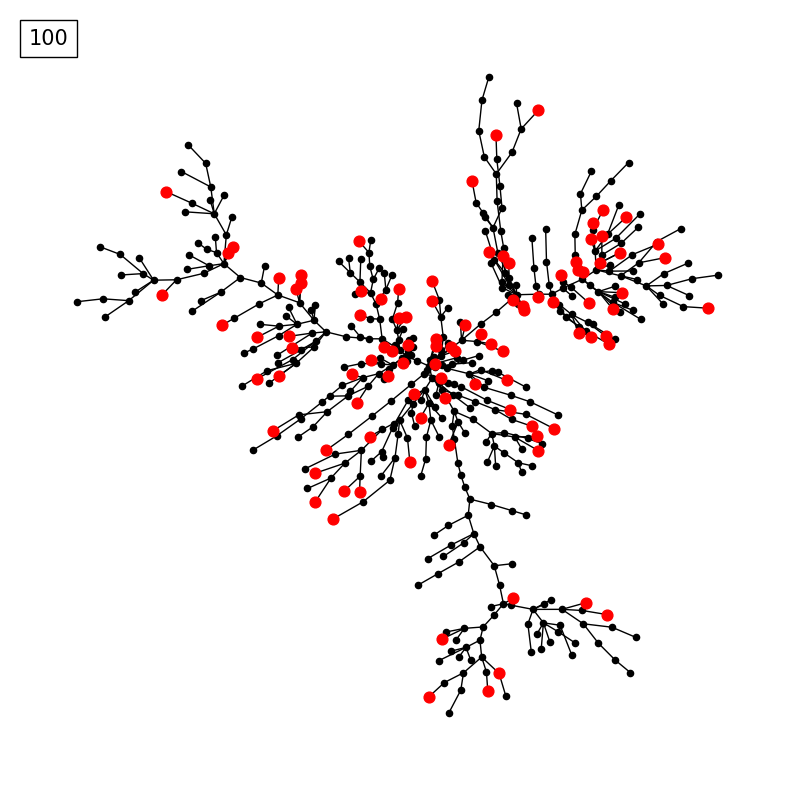

In [8]:
from matplotlib.offsetbox import AnchoredText
for rebalancedate in ['2021-08-01']:
    rb_date= str(rebalancedate)
    idx_for_slicing = SP500_FULL.index[SP500_FULL.index < str(rebalancedate)[:10]].tolist()
    sliced_df = SP500_FULL[idx_for_slicing[-121]:idx_for_slicing[-1]].copy()
    
    date_for_srch = rb_date[:10]
    dropped_mat = sliced_df.dropna(axis='columns')
    asset_log_return =  np.log(dropped_mat/dropped_mat.shift(periods=1))
    asset_log_return = asset_log_return[1:].fillna(method = 'ffill')
    
    cov_mat = asset_log_return.cov()
    asset_log_return = asset_log_return.apply(lambda x: (x-x.mean())/ x.std(), axis=0).dropna(axis='columns')
    corr_mat = asset_log_return.corr()

    corr_dist_mat = np.sqrt(2*(1-corr_mat)) #distance metric으로 변환 (대각행렬 1로 변환안한 상태)
    diag0_corr_dist_mat = corr_dist_mat.copy()
    
    corr_dist_mat_ED_D = 1 + corr_mat #EC, D
    diag0_corr_dist_mat_ED_D = corr_dist_mat_ED_D.copy()
    
    for num in range(0,len(corr_dist_mat)):
        
        diag0_corr_dist_mat.iloc[num,num] = 0
        diag0_corr_dist_mat_ED_D.iloc[num,num] = 0
        
    X = nx.from_pandas_adjacency(diag0_corr_dist_mat.astype(np.float64))
    MST = nx.minimum_spanning_tree(X, weight='weight')
    MST_dataframe = nx.to_pandas_adjacency(MST,nodelist=corr_dist_mat.columns,dtype=np.float64)
    unweighted_MST = nx.from_pandas_adjacency(MST_dataframe[MST_dataframe==0].fillna(1).astype(np.float64))
    
    X2 = nx.from_pandas_adjacency(diag0_corr_dist_mat_ED_D.astype(np.float64))
    MST2 = nx.minimum_spanning_tree(X2, weight='weight')
    MST_dataframe2 = nx.to_pandas_adjacency(MST2,nodelist=corr_dist_mat.columns,dtype=np.float64)
    unweighted_MST2 = nx.from_pandas_adjacency(MST_dataframe2[MST_dataframe2==0].fillna(1).astype(np.float64))
    
    D = Degree_rank(MST2,unweighted_MST2)
    EC = Eigenvector_centrality_rank(MST2,unweighted_MST2)
    
    BC = Beteenness_centrality_rank(MST,unweighted_MST)
    E = Eccentricity_rank(MST,unweighted_MST)
    C = Closeness_centrality_rank(MST,unweighted_MST)

    D.index = D['stock']
    EC.index = EC['stock']
    BC.index = BC['stock']
    E.index = E['stock']
    C.index = C['stock']
    
    X = (D.iloc[:,3]+D.iloc[:,4]+BC.iloc[:,3]+BC.iloc[:,4]-4)/(4*(len(corr_dist_mat)-1))
    Y = (E.iloc[:,3]+E.iloc[:,4]+C.iloc[:,3]+C.iloc[:,4]+EC.iloc[:,3]+EC.iloc[:,4]-6)/(6*(len(corr_dist_mat)-1))
    
    peripheralityMeasure = (X+Y).to_frame()
    sortedPeripheralityMeasure = peripheralityMeasure.sort_values(by=0,ascending=False)
    
    hierarcgy_link = sch.linkage(corr_dist_mat,'single')
    sortIx = getQuasiDiag(hierarcgy_link)
    sortIx = corr_mat.index[sortIx].tolist()
    hrp = getRecBipart(cov_mat, sortIx).sort_index()
    
    top300 = sortedPeripheralityMeasure[:300].index
    
    top200 = sortedPeripheralityMeasure[:200].index
    
    top100 = sortedPeripheralityMeasure[:100].index
    
    top50 = sortedPeripheralityMeasure[:50].index
    
    top30 = sortedPeripheralityMeasure[:30].index
    
    top20 = sortedPeripheralityMeasure[:20].index
    
    top10 = sortedPeripheralityMeasure[:10].index
    
    top5 = sortedPeripheralityMeasure[:5].index
    
    pos = nx.kamada_kawai_layout(MST)
    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(top5), pos=pos, node_color="red",node_size=60)   
    anchored_text = AnchoredText("5", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)
    
    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(top10), pos=pos, node_color="red",node_size=60)   
    anchored_text = AnchoredText("10", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  

    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(top20), pos=pos, node_color="red",node_size=60)   
    anchored_text = AnchoredText("20", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  
    
    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(top30), pos=pos, node_color="red",node_size=60)   
    anchored_text = AnchoredText("30", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  
    
    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(top50), pos=pos, node_color="red",node_size=60)   
    anchored_text = AnchoredText("50", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  

    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(top100), pos=pos, node_color="red",node_size=60)   
    anchored_text = AnchoredText("100", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  

Figure 4. Snapshots of the global motion subtracted correlation MST

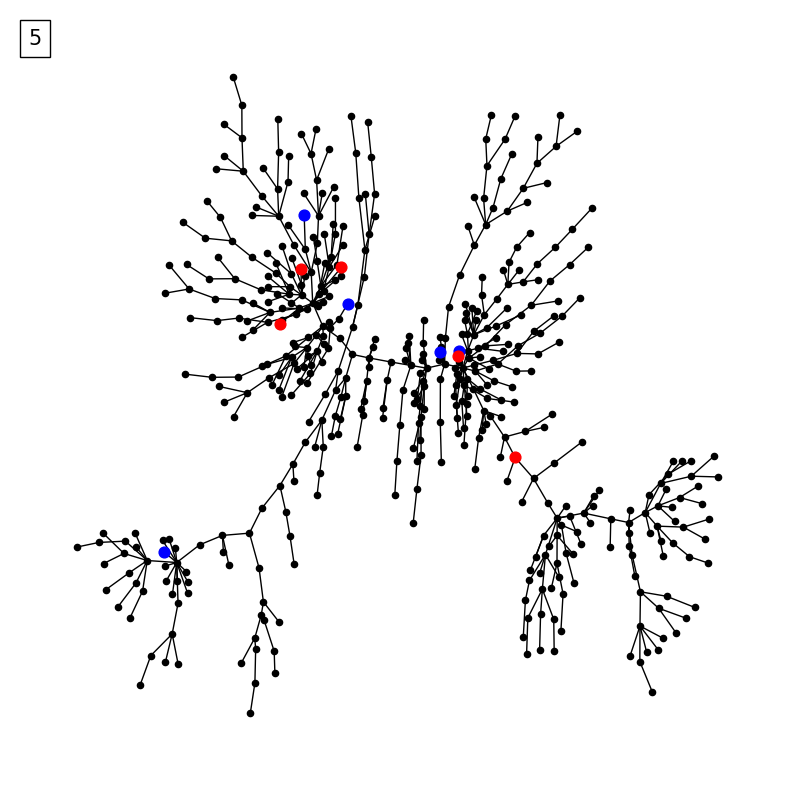

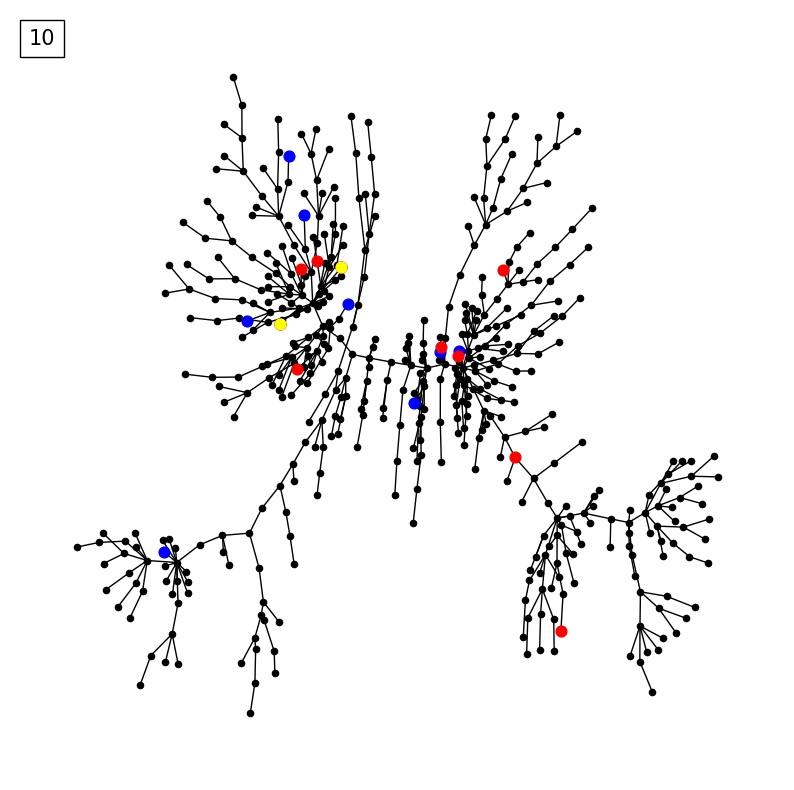

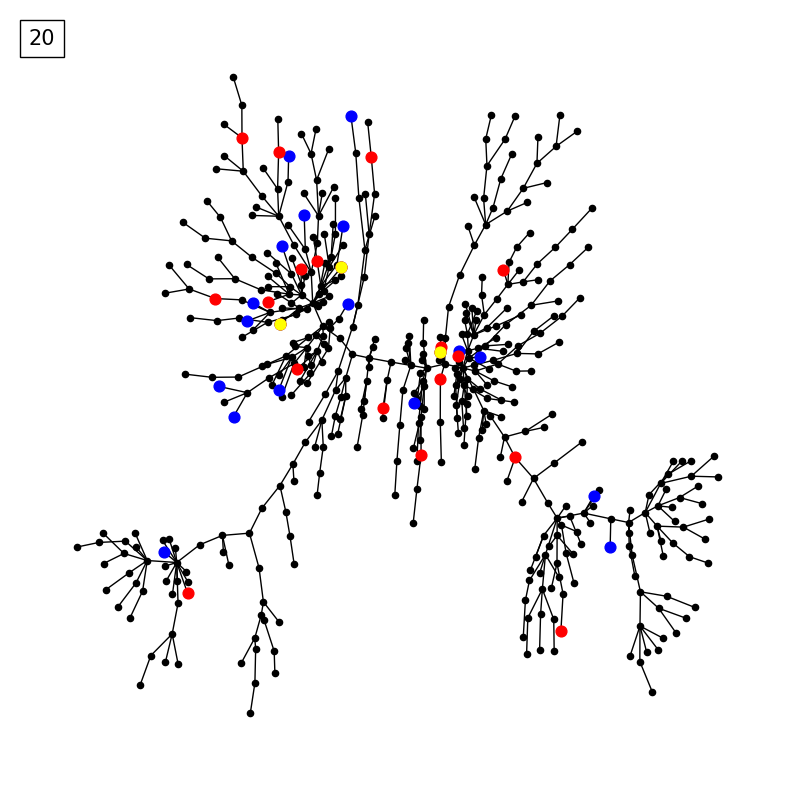

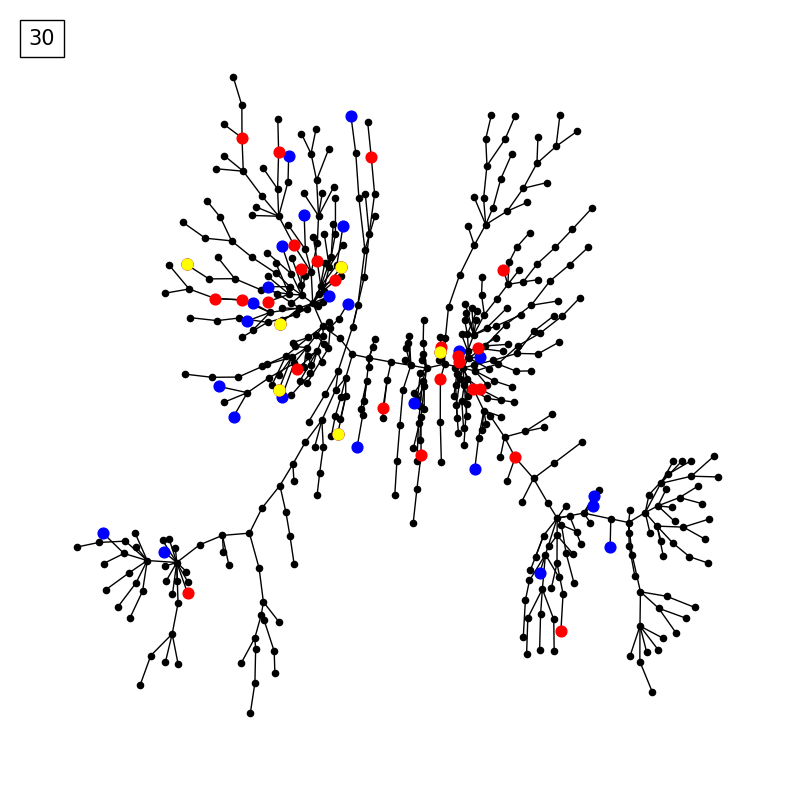

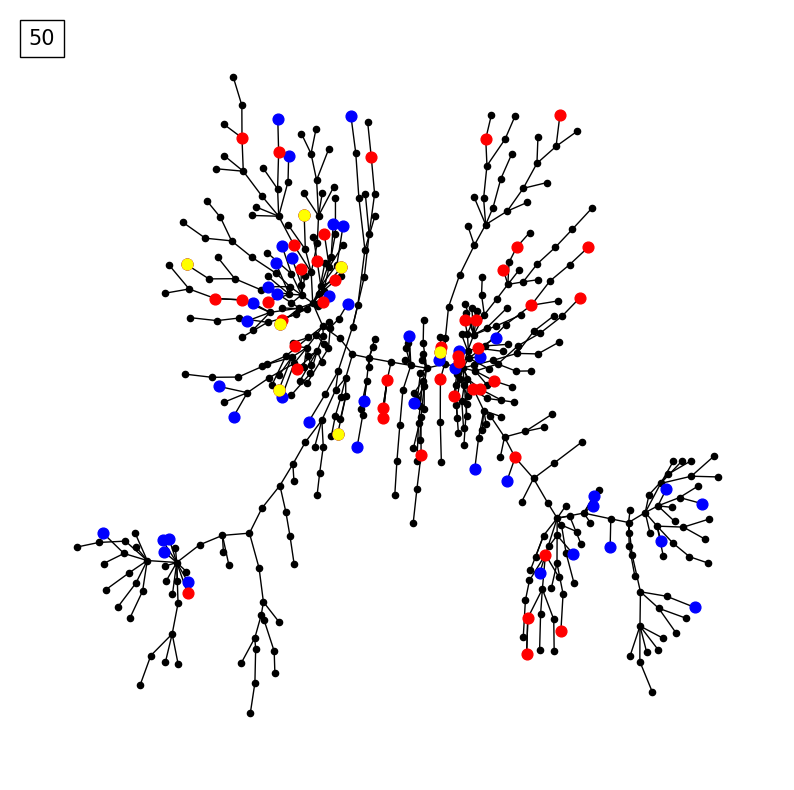

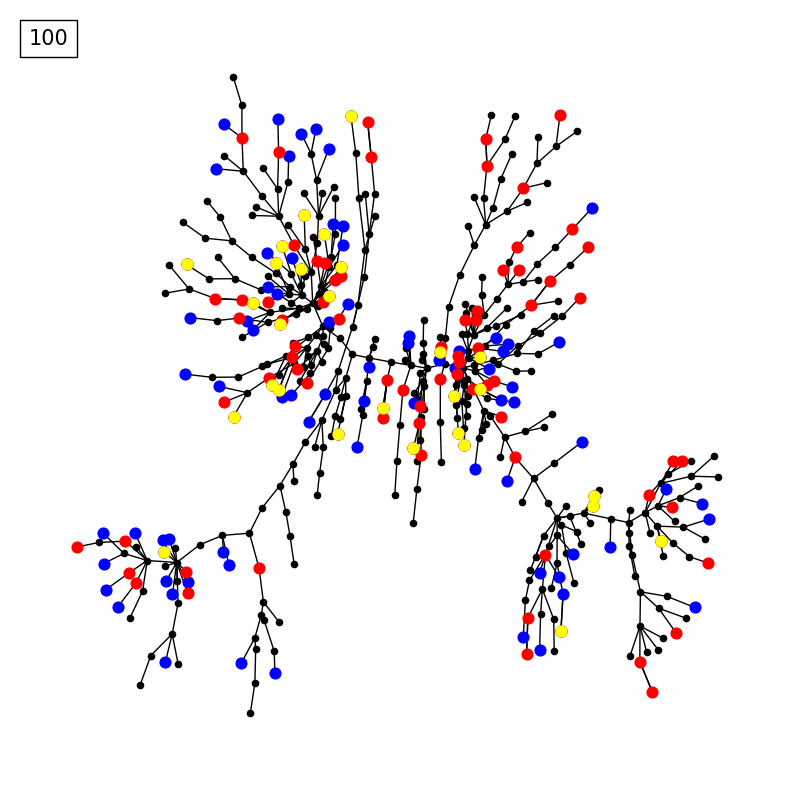

In [9]:
for rebalancedate in ['2021-08-01']:
    rb_date= str(rebalancedate)
    idx_for_slicing = SP500_FULL.index[SP500_FULL.index < str(rebalancedate)[:10]].tolist()
    sliced_df = SP500_FULL[idx_for_slicing[-121]:idx_for_slicing[-1]].copy()
    
    date_for_srch = rb_date[:10]
    dropped_mat = sliced_df.dropna(axis='columns')
    asset_log_return =  np.log(dropped_mat/dropped_mat.shift(periods=1))
    asset_log_return = asset_log_return[1:].fillna(method = 'ffill')
    cov_mat = asset_log_return.cov()
    
    asset_log_return = asset_log_return.apply(lambda x: (x-x.mean())/ x.std(), axis=0).dropna(axis='columns')
    corr_mat = asset_log_return.corr()
    
    w,v = np.linalg.eigh(corr_mat) 
    # w is a 1-D array containing the eigenvalues
    # v is a 2-D square array or matrix (depending on the input type) of the corresponding eigenvectors (in columns)
    # The largest eigenvalue is in the last row of w.
    # The column v[:, i] is the normalized eigenvector corresponding to the eigenvalue w[i].
    globalMotion = w[-1] * np.dot(v[:, -1].reshape(-1,1),v[:, -1].reshape(1,-1))
    globalMotion = pd.DataFrame(globalMotion,index=asset_log_return.columns,columns=asset_log_return.columns).astype(np.float64)
    corr_mat_without_globalMotion = corr_mat - globalMotion
    
    corr_dist_mat = np.sqrt(2*(1-corr_mat_without_globalMotion)) #distance metric으로 변환 (대각행렬 1로 변환안한 상태)
    
    diag0_corr_dist_mat = corr_dist_mat.copy()
    
    corr_dist_mat_ED_D = 1 + corr_mat_without_globalMotion #EC, D
    diag0_corr_dist_mat_ED_D = corr_dist_mat_ED_D.copy()
    
    for num in range(0,len(corr_mat_without_globalMotion)):
        
        diag0_corr_dist_mat.iloc[num,num] = 0
        diag0_corr_dist_mat_ED_D.iloc[num,num] = 0
        
    X = nx.from_pandas_adjacency(diag0_corr_dist_mat.astype(np.float64))
    MST = nx.minimum_spanning_tree(X, weight='weight')
    MST_dataframe = nx.to_pandas_adjacency(MST,nodelist=corr_dist_mat.columns,dtype=np.float64)
    unweighted_MST = nx.from_pandas_adjacency(MST_dataframe[MST_dataframe==0].fillna(1).astype(np.float64))
    
    X2 = nx.from_pandas_adjacency(diag0_corr_dist_mat_ED_D.astype(np.float64))
    MST2 = nx.minimum_spanning_tree(X2, weight='weight')
    MST_dataframe2 = nx.to_pandas_adjacency(MST2,nodelist=corr_dist_mat.columns,dtype=np.float64)
    unweighted_MST2 = nx.from_pandas_adjacency(MST_dataframe2[MST_dataframe2==0].fillna(1).astype(np.float64))
    
    D = Degree_rank(MST2,unweighted_MST2)
    EC = Eigenvector_centrality_rank(MST2,unweighted_MST2)
    
    BC = Beteenness_centrality_rank(MST,unweighted_MST)
    E = Eccentricity_rank(MST,unweighted_MST)
    C = Closeness_centrality_rank(MST,unweighted_MST)
    
    D.index = D['stock']
    EC.index = EC['stock']
    BC.index = BC['stock']
    E.index = E['stock']
    C.index = C['stock']
    
    X = (D.iloc[:,3]+D.iloc[:,4]+BC.iloc[:,3]+BC.iloc[:,4]-4)/(4*(len(corr_mat_without_globalMotion)-1))
    Y = (E.iloc[:,3]+E.iloc[:,4]+C.iloc[:,3]+C.iloc[:,4]+EC.iloc[:,3]+EC.iloc[:,4]-6)/(6*(len(corr_mat_without_globalMotion)-1))
    
    peripheralityMeasure = (X+Y).to_frame()
    sortedPeripheralityMeasure = peripheralityMeasure.sort_values(by=0,ascending=False)
    
    hierarcgy_link = sch.linkage(corr_dist_mat,'single')
    sortIx = getQuasiDiag(hierarcgy_link)
    sortIx = corr_mat_without_globalMotion.index[sortIx].tolist()
    hrp = getRecBipart(cov_mat, sortIx).sort_index()
    
    sub_top300 = sortedPeripheralityMeasure[:300].index
    
    sub_top200 = sortedPeripheralityMeasure[:200].index
    
    sub_top100 = sortedPeripheralityMeasure[:100].index
    
    sub_top50 = sortedPeripheralityMeasure[:50].index
    
    sub_top30 = sortedPeripheralityMeasure[:30].index
    
    sub_top20 = sortedPeripheralityMeasure[:20].index
    
    sub_top10 = sortedPeripheralityMeasure[:10].index
    
    sub_top5 = sortedPeripheralityMeasure[:5].index
    
    pos = nx.kamada_kawai_layout(MST)
    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    intersection = set(top5) & set(sub_top5)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(sub_top5), pos=pos, node_color="blue",node_size=60)
    nx.draw(MST.subgraph(top5), pos=pos, node_color="red",node_size=60)   
    nx.draw(MST.subgraph(intersection), pos=pos, node_color="yellow",node_size=60)   
    anchored_text = AnchoredText("5", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)
    
    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    intersection = set(top10) & set(sub_top10)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(sub_top10), pos=pos, node_color="blue",node_size=60)
    nx.draw(MST.subgraph(top10), pos=pos, node_color="red",node_size=60)
    nx.draw(MST.subgraph(intersection), pos=pos, node_color="yellow",node_size=60)  
    anchored_text = AnchoredText("10", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  

    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    intersection = set(top20) & set(sub_top20)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(sub_top20), pos=pos, node_color="blue",node_size=60)
    nx.draw(MST.subgraph(top20), pos=pos, node_color="red",node_size=60)   
    nx.draw(MST.subgraph(intersection), pos=pos, node_color="yellow",node_size=60)  
    anchored_text = AnchoredText("20", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  
    
    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    intersection = set(top30) & set(sub_top30)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(sub_top30), pos=pos, node_color="blue",node_size=60)   
    nx.draw(MST.subgraph(top30), pos=pos, node_color="red",node_size=60)   
    nx.draw(MST.subgraph(intersection), pos=pos, node_color="yellow",node_size=60)  
    anchored_text = AnchoredText("30", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  
    
    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    intersection = set(top50) & set(sub_top50)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(sub_top50), pos=pos, node_color="blue",node_size=60) 
    nx.draw(MST.subgraph(top50), pos=pos, node_color="red",node_size=60)   
    nx.draw(MST.subgraph(intersection), pos=pos, node_color="yellow",node_size=60)  
    anchored_text = AnchoredText("50", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text)  

    f, axes = plt.subplots(1,1,figsize=(10,10))
    plt.subplot(1,1,1)
    intersection = set(top100) & set(sub_top100)
    nx.draw(MST, pos=pos,node_size=20, node_color='black')
    nx.draw(MST.subgraph(sub_top100), pos=pos, node_color="blue",node_size=60)   
    nx.draw(MST.subgraph(top100), pos=pos, node_color="red",node_size=60)   
    nx.draw(MST.subgraph(intersection), pos=pos, node_color="yellow",node_size=60)  
    anchored_text = AnchoredText("100", loc='upper left',prop=dict(size=15))
    axes.add_artist(anchored_text) 

Figure 3. Snapshots of full cross-correlation, global motion, global motion subtracted correlation matrices on August 1, 2021.

/var/folders/tq/5vll538x41n7rfrrk7682rbh0000gn/T/ipykernel_52870/717659770.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hierarcgy_link = sch.linkage(corr_dist_mat,'single')
/var/folders/tq/5vll538x41n7rfrrk7682rbh0000gn/T/ipykernel_52870/717659770.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


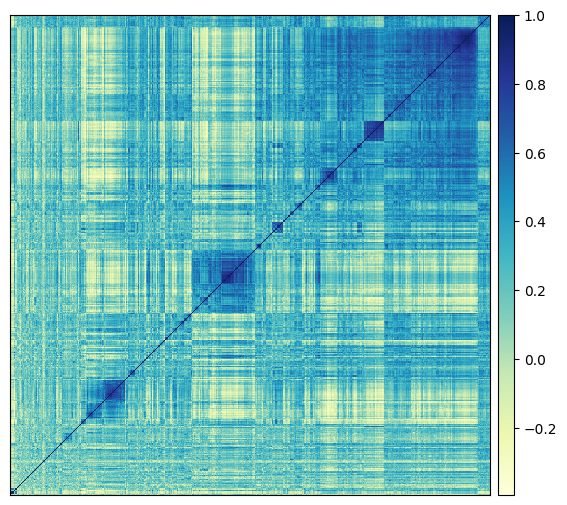

In [12]:
fig = pylab.figure(figsize=(8,8))

idx_for_slicing = SP500_FULL.index[SP500_FULL.index < str(rebalancedate)[:10]].tolist()
sliced_df = SP500_FULL[idx_for_slicing[-121]:idx_for_slicing[-1]].copy()
date_for_srch = rb_date[:10]
dropped_mat = sliced_df.dropna(axis='columns')
asset_log_return =  np.log(dropped_mat/dropped_mat.shift(periods=1))
asset_log_return = asset_log_return[1:].fillna(method = 'ffill')
asset_log_return = asset_log_return.apply(lambda x: (x-x.mean())/ x.std(), axis=0).dropna(axis='columns')
corr_mat = asset_log_return.corr()

corr_dist_mat = np.sqrt(2*(1-corr_mat))
    
hierarcgy_link = sch.linkage(corr_dist_mat,'single')
sortIx = getQuasiDiag(hierarcgy_link)
sortIx = corr_mat.index[sortIx].tolist()

axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])

im = axmatrix.matshow(corr_mat.loc[sortIx,sortIx], aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()

/var/folders/tq/5vll538x41n7rfrrk7682rbh0000gn/T/ipykernel_52870/3834631246.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


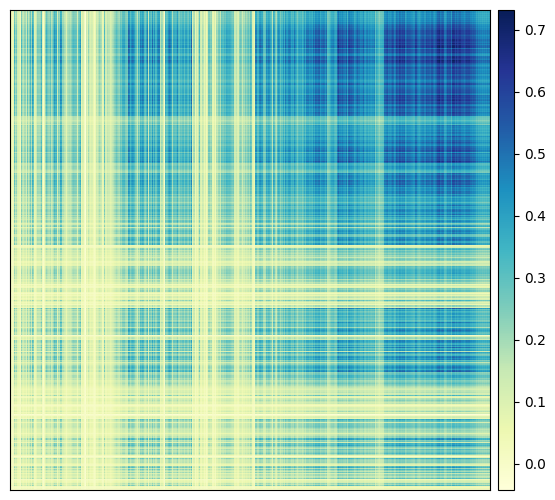

In [13]:
fig = pylab.figure(figsize=(8,8))

idx_for_slicing = SP500_FULL.index[SP500_FULL.index < str(rebalancedate)[:10]].tolist()
sliced_df = SP500_FULL[idx_for_slicing[-121]:idx_for_slicing[-1]].copy()
date_for_srch = rb_date[:10]
dropped_mat = sliced_df.dropna(axis='columns')
asset_log_return =  np.log(dropped_mat/dropped_mat.shift(periods=1))
asset_log_return = asset_log_return[1:].fillna(method = 'ffill')
asset_log_return = asset_log_return.apply(lambda x: (x-x.mean())/ x.std(), axis=0).dropna(axis='columns')
corr_mat = asset_log_return.corr()

w,v = np.linalg.eigh(corr_mat)
globalMotion = w[-1] * np.dot(v[:, -1].reshape(-1,1),v[:, -1].reshape(1,-1))
globalMotion = pd.DataFrame(globalMotion,index=asset_log_return.columns,columns=asset_log_return.columns).astype(np.float64)

corr_dist_mat = np.sqrt(2*(1-globalMotion))
    
# hierarcgy_link = sch.linkage(corr_dist_mat,'single')
# sortIx = getQuasiDiag(hierarcgy_link)
# sortIx = globalMotion.index[sortIx].tolist()

axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])

im = axmatrix.matshow(globalMotion.loc[sortIx,sortIx], aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()

/var/folders/tq/5vll538x41n7rfrrk7682rbh0000gn/T/ipykernel_52870/541539440.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


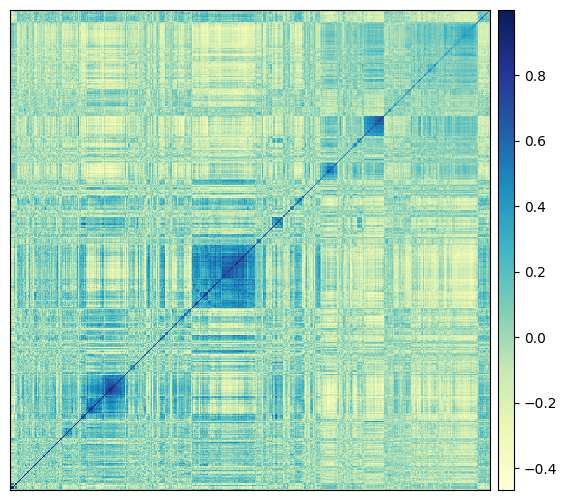

In [14]:
fig = pylab.figure(figsize=(8,8))

idx_for_slicing = SP500_FULL.index[SP500_FULL.index < str(rebalancedate)[:10]].tolist()
sliced_df = SP500_FULL[idx_for_slicing[-121]:idx_for_slicing[-1]].copy()
date_for_srch = rb_date[:10]
dropped_mat = sliced_df.dropna(axis='columns')
asset_log_return =  np.log(dropped_mat/dropped_mat.shift(periods=1))
asset_log_return = asset_log_return[1:].fillna(method = 'ffill')
asset_log_return = asset_log_return.apply(lambda x: (x-x.mean())/ x.std(), axis=0).dropna(axis='columns')
corr_mat = asset_log_return.corr()

w,v = np.linalg.eigh(corr_mat)
globalMotion = w[-1] * np.dot(v[:, -1].reshape(-1,1),v[:, -1].reshape(1,-1))
globalMotion = pd.DataFrame(globalMotion,index=asset_log_return.columns,columns=asset_log_return.columns).astype(np.float64)
corr_mat_without_globalMotion = corr_mat - globalMotion

corr_dist_mat = np.sqrt(2*(1-corr_mat_without_globalMotion))

axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])

im = axmatrix.matshow(corr_mat_without_globalMotion.loc[sortIx,sortIx], aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()

/var/folders/tq/5vll538x41n7rfrrk7682rbh0000gn/T/ipykernel_52870/3745265220.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


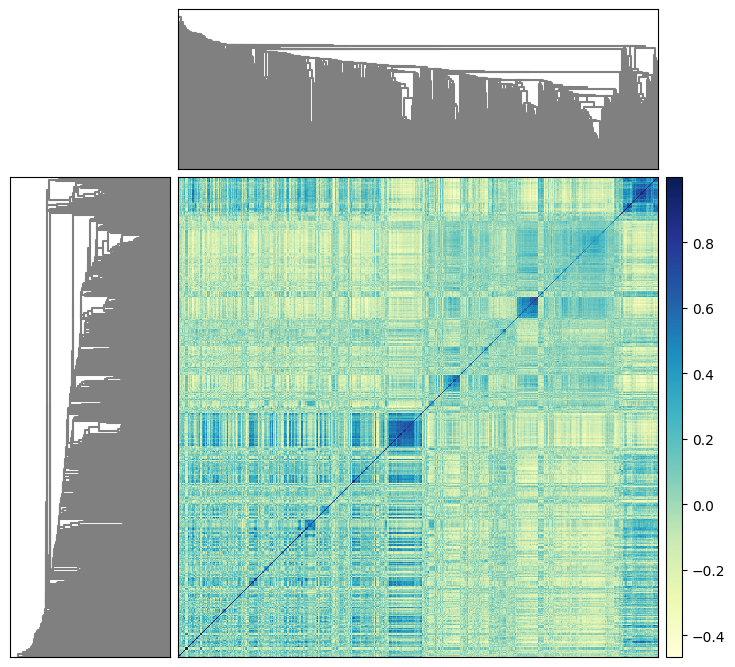

In [15]:
fig = pylab.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09,0.1,0.2,0.6])

idx_for_slicing = SP500_FULL.index[SP500_FULL.index < str(rebalancedate)[:10]].tolist()
sliced_df = SP500_FULL[idx_for_slicing[-121]:idx_for_slicing[-1]].copy()
date_for_srch = rb_date[:10]
dropped_mat = sliced_df.dropna(axis='columns')
asset_log_return =  np.log(dropped_mat/dropped_mat.shift(periods=1))
asset_log_return = asset_log_return[1:].fillna(method = 'ffill')
asset_log_return = asset_log_return.apply(lambda x: (x-x.mean())/ x.std(), axis=0).dropna(axis='columns')
corr_mat = asset_log_return.corr()

w,v = np.linalg.eigh(corr_mat)
globalMotion = w[-1] * np.dot(v[:, -1].reshape(-1,1),v[:, -1].reshape(1,-1))
globalMotion = pd.DataFrame(globalMotion,index=asset_log_return.columns,columns=asset_log_return.columns).astype(np.float64)
corr_mat_without_globalMotion = corr_mat - globalMotion

corr_dist_mat = np.sqrt(2*(1-corr_mat_without_globalMotion))
    
hierarcgy_link = sch.linkage(corr_dist_mat,'single')
sortIx = getQuasiDiag(hierarcgy_link)
sortIx = corr_mat_without_globalMotion.index[sortIx].tolist()
Z1 = sch.dendrogram(hierarcgy_link, orientation='left', color_threshold=0 ,above_threshold_color='grey')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z2 = sch.dendrogram(hierarcgy_link, color_threshold=0, above_threshold_color='grey')
ax2.set_xticks([])
ax2.set_yticks([])
f = getQuasiDiag(hierarcgy_link)
f = globalMotion.index[f].tolist()
# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

im = axmatrix.matshow(corr_mat_without_globalMotion.loc[sortIx,sortIx], aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
fig.show()

Figure 1. The probability density function of the eigenvalues from S&P500 on August 1, 2021.

In [16]:
spClose = pd.read_csv('SP500_FULL.csv',index_col='Unnamed: 0') 
idx_for_slicing = spClose.index[spClose.index < str('2021-08-01')[:10]].tolist()
sliced_df = spClose[idx_for_slicing[-121]:idx_for_slicing[-1]].copy()

In [17]:
sliced_df = sliced_df.dropna(axis='columns')
logReturn1 = np.log(sliced_df).diff().dropna()
for i in range(0,10):
    shuffled_logReturn1 = logReturn1.apply(lambda x:  np.random.permutation(x),axis=0)

scaledLogReturn1 = logReturn1.apply(lambda x: (x-x.mean())/ x.std(), axis=0).dropna(axis='columns')
corrMat = scaledLogReturn1.corr()

scaledShuffledLogReturn1 = shuffled_logReturn1.apply(lambda x: (x-x.mean())/ x.std(), axis=0).dropna(axis='columns')
shuffledCorrMat = scaledShuffledLogReturn1.corr()

lambda_MP_dist = scaledLogReturn1.shape[1]/scaledLogReturn1.shape[0]

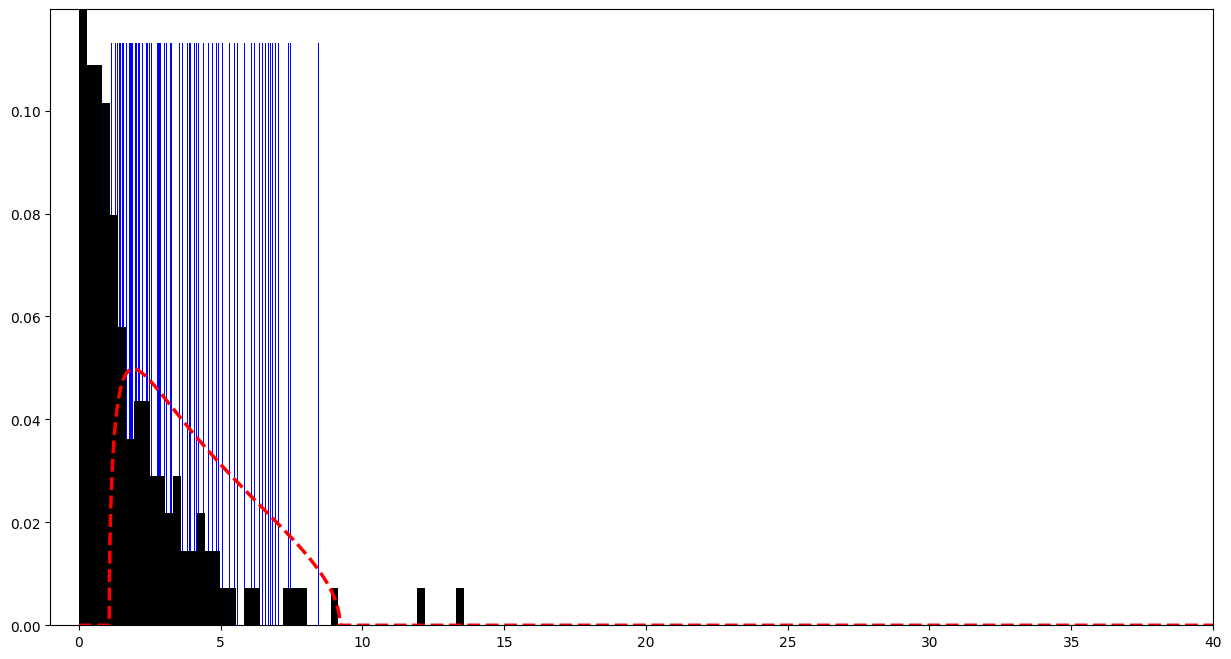

In [ ]:
def marchpast(l, g):
    "Marchenko-Pastur distribution"
    def m0(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    lambda_max=(1+g**0.5)**2
    lambda_min=(1-g**0.5)**2
    return np.sqrt(  m0(lambda_max  - l) *  m0(l- lambda_min)) / ( 2*np.pi*g*l), lambda_max

plt.figure(figsize=(15,8))
w,v = np.linalg.eigh(shuffledCorrMat)
nn, bb, patches=plt.hist(w.ravel(), 
                            bins=scaledShuffledLogReturn1.shape[1], 
                            density=True,
                            color='blue',alpha=1,
                            label='Surrogate correlation matrix')

w,v = np.linalg.eigh(corrMat)
nn, bb, patches=plt.hist(w.ravel(), 
                            bins=scaledLogReturn1.shape[1], 
                            density=True,
                            color='black',alpha=1,
                            label='Empirical correlation matrix')
x=np.arange(bb[0], bb[-1], 0.003)
theoretical_values, lambda_max = marchpast(x, lambda_MP_dist)
plt.plot(x,theoretical_values,color='red',linestyle='--',
         label=f'Marchenko-Pastur distribution (y={round(lambda_MP_dist,2)})',
        linewidth=2.5)
plt.ylim(top=nn[1:].max() * 1.1)
plt.xlim((-1,40))
plt.savefig('bbox_plt.jpg',bbox_inches='tight')

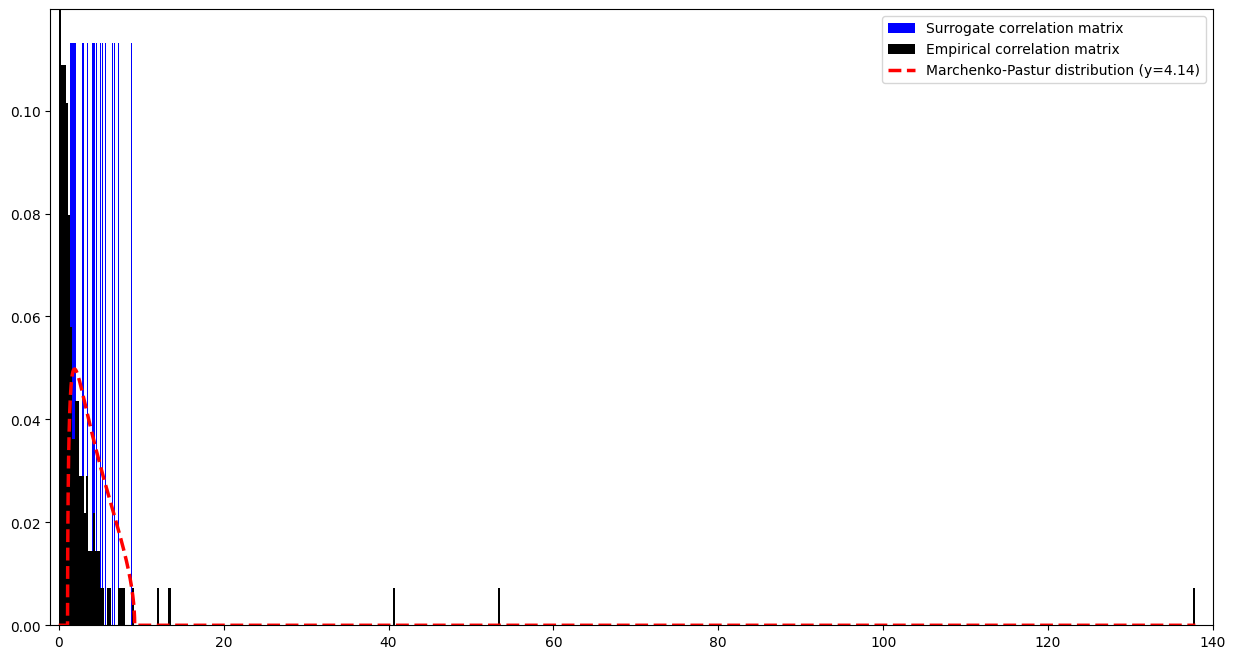

In [19]:
def marchpast(l, g):
    "Marchenko-Pastur distribution"
    def m0(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    lambda_max=(1+g**0.5)**2
    lambda_min=(1-g**0.5)**2
    return np.sqrt(  m0(lambda_max  - l) *  m0(l- lambda_min)) / ( 2*np.pi*g*l), lambda_max

plt.figure(figsize=(15,8))
w,v = np.linalg.eigh(shuffledCorrMat)
nn, bb, patches=plt.hist(w.ravel(), 
                            bins=scaledShuffledLogReturn1.shape[1], 
                            density=True,
                            color='blue',alpha=1,
                            label='Surrogate correlation matrix')

w,v = np.linalg.eigh(corrMat)
nn, bb, patches=plt.hist(w.ravel(), 
                            bins=scaledLogReturn1.shape[1], 
                            density=True,
                            color='black',alpha=1,
                            label='Empirical correlation matrix')
x=np.arange(bb[0], bb[-1], 0.003)
theoretical_values, lambda_max = marchpast(x, lambda_MP_dist)
plt.plot(x,theoretical_values,color='red',linestyle='--',
         label=f'Marchenko-Pastur distribution (y={round(lambda_MP_dist,2)})',
        linewidth=2.5)
plt.ylim(top=nn[1:].max() * 1.1)
plt.xlim((-1,140))
plt.legend()